In [ ]:
import jax
import optax
from orbax.checkpoint import PyTreeCheckpointer
from flax.training.train_state import TrainState

from lotf import LOTF_PATH
from lotf.envs import HoveringFeaturesEnv, rollout
from lotf.modules import MLP
from lotf.objects import Quadrotor

%matplotlib inline

# Evaluating a Trained Feature-based Hovering Policy

## 1. Seed

In [2]:
seed = 0
key = jax.random.key(seed)
key_init, key_bptt = jax.random.split(key, 2)

## 2. Define Simulation Dynamics Config

In [3]:
# simulation dynamics config
sim_dyn_config = {
    "use_high_fidelity": False,          # whether to use high-fidelity dynamics in forward simulation
    "use_forward_residual": False,       # whether to use residual dynamics in forward simulation
}
# NOTE: To evaluate under residual dynamics, simply set "forward_residual" to True in the config above
path = LOTF_PATH + "/../checkpoints/residual_dynamics/dummy_params"
ckptr = PyTreeCheckpointer()
dummy_residual_params = ckptr.restore(path)

## 3. Create Quadrotor Object and Evaluation Environment

In [4]:
# simulation parameters
sim_dt = 0.02
max_sim_time = 10.0

# quadrotor object
quad_obj = Quadrotor.from_name("example_quad", sim_dyn_config)

eval_env = HoveringFeaturesEnv(
    max_steps_in_episode=int(max_sim_time / sim_dt),
    dt=sim_dt,
    delay=0.04,
    quad_obj=quad_obj,
    num_last_quad_states=15,
    skip_frames=3,
    margin=0.5,
    hover_target=[1.5, 0.0, 1.5],
)

# get dims
action_dim = eval_env.action_space.shape[0]
obs_dim = eval_env.observation_space.shape[0]

print("====== eval_env info ======")
print(f"action_dim: {action_dim}")
print(f"obs_dim: {obs_dim}")

====== eval_env info ======
action_dim: 4
obs_dim: 82


## 4. Load the Trained Policy

In [5]:
policy_name = "vision_hovering_params"

# create policy network
base_policy_net = MLP(
    [obs_dim, 512, 512, action_dim],
    action_bias=eval_env.hovering_action,
)

path = LOTF_PATH + "/../checkpoints/policy/" + policy_name
ckptr = PyTreeCheckpointer()
base_policy_params = ckptr.restore(path)
loaded_train_state = TrainState.create(apply_fn=base_policy_net.apply, params=base_policy_params, tx=optax.adam(1e-3))

# define policy function
def policy_trained(obs, key):
    return loaded_train_state.apply_fn(loaded_train_state.params, obs)

## 5. Rollout the Policy and Plot Results

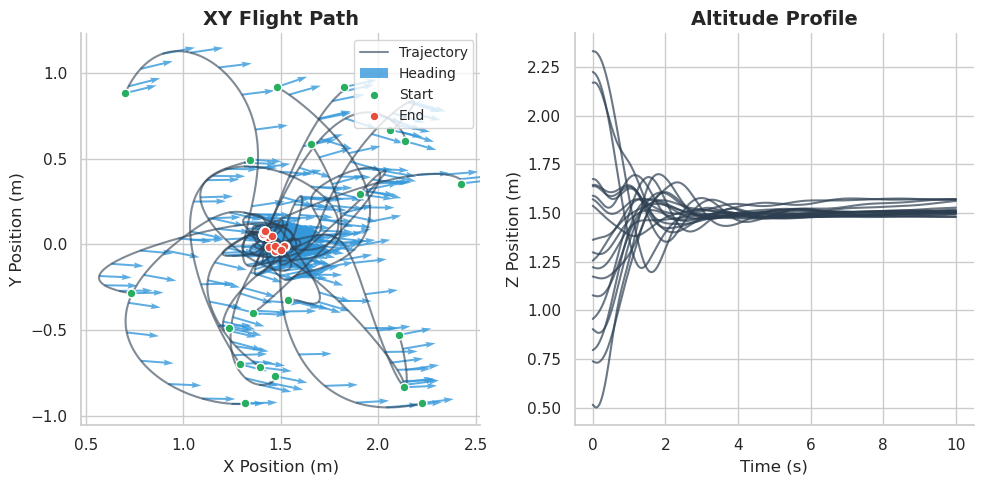

In [6]:
def get_rollouts(env, policy, num_rollouts, key):
    parallel_rollout = jax.vmap(rollout, in_axes=(None, 0, None, None))
    rollout_keys = jax.random.split(key, num_rollouts)
    transitions = parallel_rollout(env, rollout_keys, policy, dummy_residual_params)
    return transitions

transitions_eval = get_rollouts(eval_env, policy_trained, 20, jax.random.key(0))
eval_env.plot_trajectories(transitions_eval)